初始点的随机选取

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=0)
xyz_grid = [[x, y, z] for z in range(10) for y in range(10) for x in range(10)]
xyz = rng.choice(xyz_grid, 64, replace=False) #随机在元胞内取64个点

初始速度随机生成

In [2]:
v = []
for i in range(64):
    v.append(rng.uniform(-1, 1, 3).tolist())
v = np.array(v)

定义PBC函数和L-J势

In [3]:
def pbc(r, ref, L): #注意这里的变量都是三维列表，表示坐标
    for i in range(3):
        while (r - ref)[i] > L/2:
            r[i] -= L
        while (ref - r)[i] > L/2:
            r[i] += L
    return r

def distance(r1, r2):
    d = 0
    d += sum((r1-r2)**2)
    return np.sqrt(d)

def LJ_Force(xyz, N): #第一个粒子受到的力
    F = []
    for k in range(N):
        Fk = [0, 0, 0]
        xyz_i = xyz.copy()
        #最小像力平移
        for i in range(N):
            if(i!=k):
                xyz_i[i] = pbc(xyz_i[i], xyz_i[k], 10)

        for i in range(3):
            for j in range(len(xyz)):
                if(j!=k):
                    r = distance(xyz_i[k], xyz_i[j])
                    Fk[i] += 48 * (xyz_i[k,i] - xyz_i[j,i]) * (r**(-14) - 0.5 * r**(-8))  
        F.append(Fk)

    return np.array(F)



verlet算法计算200步之后的速度和位置

In [4]:
t = 0.02

x0 = xyz 
v0 = v.copy()

N = 200

vp = np.empty((0,3))
xp = np.empty((0,3))

#使用x0和x1交替存储两步的数据
for i in range(N):
    x1 = x0 + t*v0 + LJ_Force(x0, 64)*t*t/2
    v1 = v0 + t*(LJ_Force(x1, 64) + LJ_Force(x0, 64))/2
    #周期性边界
    for j in range(64):
        x1[j] = pbc(x1[j], 10/2, 10)
    x0 = x1
    v0 = v1
    #合并作图
    if(N - i < 8):
        vp = np.vstack((vp,v1)) 
        xp = np.vstack((xp,x1)) 

    

作图：速度分布
一维直方图（蓝色为Maxwell理论曲线）

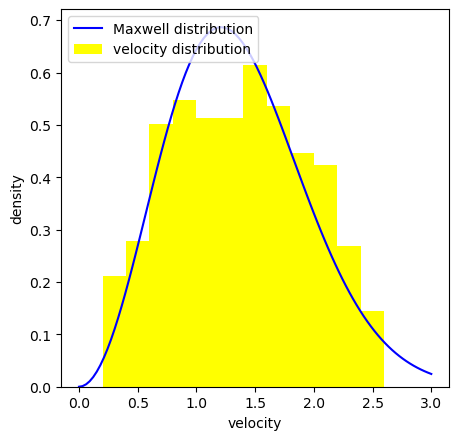

In [21]:
#Maxwell估计
Ek = 0.5 * np.mean(np.linalg.norm(vp, ord=2, axis=1)**2)
kT = Ek / (1.5)
X = np.linspace(0, 3, 100)
Y = 4 * np.pi * (2*np.pi*kT)**(-1.5) * X**2 * np.exp(-X**2/2/kT)

plt.figure(figsize=(5, 5), dpi=100)
plt.hist(np.linalg.norm(vp, ord=2, axis=1), bins=15, range=(0.0, 3), density=True, color='yellow', label='velocity distribution')
plt.plot(X, Y, color='blue', label='Maxwell distribution')
plt.xlabel("velocity")
plt.ylabel("density")
plt.legend(loc='upper left')
plt.show()

作图：位置分布

三维散点图  

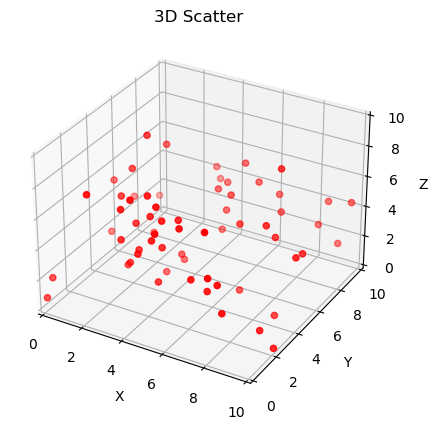

In [20]:
#作图
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = plt.axes(projection='3d')

#参考点设为图像正中心，为蓝色，其余点为红色
ax.scatter(x1[:,0], x1[:,1], x1[:,2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_xlim3d(0, 10)
ax.set_ylabel('Y')
ax.set_ylim3d(0, 10)
ax.set_zlabel('Z')
ax.set_zlim3d(0, 10)
ax.set_title("3D Scatter")
plt.show()

一维直方图 

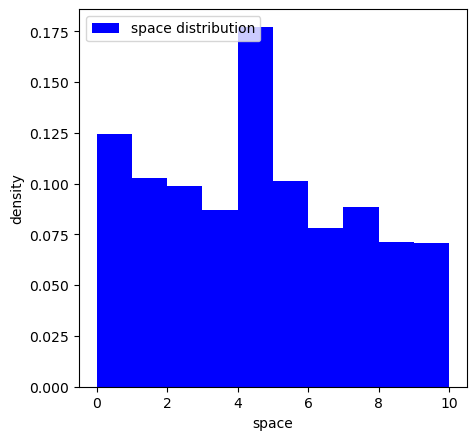

In [22]:
plt.figure(figsize=(5, 5), dpi=100)
plt.hist(abs(xp.reshape(448*3)), bins=10, range=(0.0, 10.0), density=True, color='blue', label='space distribution')
plt.legend(loc='upper left')
plt.xlabel("space")
plt.ylabel("density")
plt.show()